# Plots Table 4 experiment

In this experiment we plot the experiments were all ERA5 and gauge data is used to generate outputs

In [1]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')

import xarray as xr
import matplotlib.pyplot as plt
import GPy
import pandas as pd
import pickle
import numpy as np
import cartopy.crs as ccrs
import matplotlib.cm as cm
import cartopy.feature as cf
import matplotlib.pyplot as plt
import scipy as sp

from load import aphrodite, location_sel

ModuleNotFoundError: No module named 'cartopy'

In [2]:
! pip install cartopy

  Using cached Cartopy-0.21.1.tar.gz (10.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached shapely-2.0.1-cp38-cp38-macosx_11_0_arm64.whl (1.2 MB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for cartopy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [287 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.1-arm64-cpython-38
      creating build/lib.macosx-11.1-arm64-cpython-38/cartopy
      copying lib/cartopy/geodesic.py -> build/lib.macosx-11.1-arm64-cpython-38/cartopy
      copying lib/cartopy/_version.py -> build/lib.macosx-11.1-arm64-cpython-38/cartopy
      copying lib/cartopy/_epsg.py -> build/lib.macosx-11.1-arm64-cpython-38/cartopy
      copying lib/cartopy/util.py -> build/lib.macosx-11.1-arm64-

In [4]:
plt.rcParams.update({'font.size': 18})

## Load the data

In [7]:
# Load results
y_pred0_df = pd.read_csv('/Users/kenzatazi/Documents/CDT/Code/value_exp/table4/table4_ypred_plt_untransf5_ARD.csv', names=['y_pred'])
y_var0_df= pd.read_csv('/Users/kenzatazi/Documents/CDT/Code/value_exp/table4/table4_ystd_plt_untransf5_ARD.csv',  names=['std_pred'])
x_plt_df = pd.read_csv('/Users/kenzatazi/Documents/CDT/Code/value_exp/table4/table4_x_plt_untransf5_ARD.csv', sep=' ', names=['time', 'lon', 'lat', 'z'])

In [8]:
x_plt_df 

,time,lon,lat,z
0,2000.041667,81.90625,30.28125,5383.0
1,2000.041667,81.96875,30.28125,5071.0
2,2000.041667,81.46875,30.34375,5446.0
3,2000.041667,81.53125,30.34375,5237.0
4,2000.041667,81.71875,30.34375,4978.0
...,...,...,...,...
107095,2004.958333,78.53125,32.84375,4833.0
107096,2004.958333,78.59375,32.84375,5025.0
107097,2004.958333,78.65625,32.84375,5352.0
107098,2004.958333,78.40625,32.90625,5257.0


In [9]:
# Combine into dataframe
hf_lambda = 0.19504435748314242
x_plt_df['y_pred'] = sp.special.inv_boxcox(y_pred0_df.values, hf_lambda)
x_plt_df['95th'] = sp.special.inv_boxcox(y_pred0_df.values + 1.96 * np.sqrt(y_var0_df.values), hf_lambda)
x_plt_df['5th'] = sp.special.inv_boxcox(y_pred0_df.values - 1.96 * np.sqrt(y_var0_df.values), hf_lambda)
x_plt_df['CI'] = x_plt_df['95th'].fillna(0) - x_plt_df['5th'].fillna(0)

In [10]:
x_plt_df['5th'].max()

10.228382790480502

In [11]:
# NANs
idx = np.argwhere(np.isnan(x_plt_df['y_pred'].values)).flatten()
y_pred0_df.iloc[idx]

,y_pred
16327,-5.629752
16368,-5.310677
16369,-5.867008
16370,-5.352659
16413,-5.219149
...,...
89807,-5.137941
89873,-5.312475
89874,-5.129249
89944,-5.275441


In [12]:
# Fill NANs
x_plt_df[['y_pred', '95th', '5th', 'CI']] = x_plt_df[['y_pred', '95th', '5th', 'CI']].fillna(0)

In [30]:
# To Data Array
df = x_plt_df.reset_index()
df = df.set_index(['time', 'lon', 'lat'])
da = df.to_xarray()
da

<xarray.Dataset>
Dimensions:  (time: 60, lon: 106, lat: 43)
Coordinates:
  * time     (time) float64 2e+03 2e+03 2e+03 ... 2.005e+03 2.005e+03 2.005e+03
  * lon      (lon) float64 75.84 75.91 75.97 76.03 ... 82.22 82.28 82.34 82.41
  * lat      (lat) float64 30.28 30.34 30.41 30.47 ... 32.72 32.78 32.84 32.91
Data variables:
    index    (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    z        (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    y_pred   (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    95th     (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    5th      (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    CI       (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan

## Plots

### PDF

<AxesSubplot:>

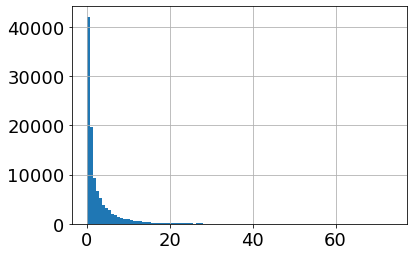

In [14]:
plt.figure()
x_plt_df['y_pred'].hist(bins=100)

### Timeseries

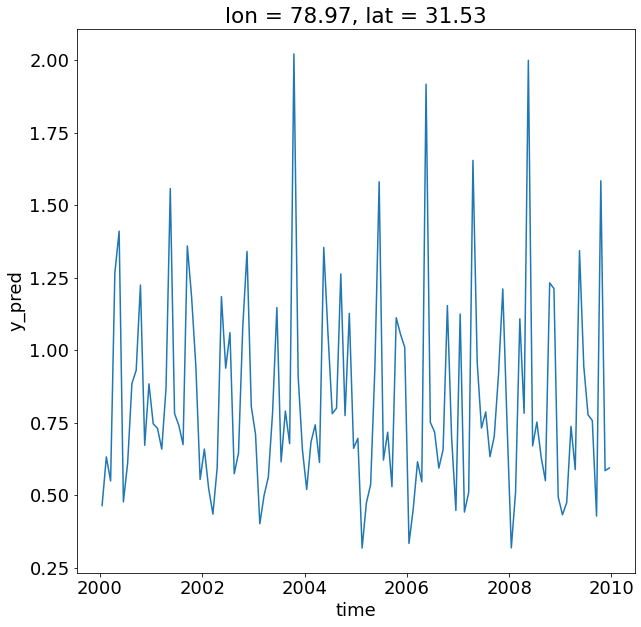

In [222]:
plt.figure(figsize=(10,10))
da.y_pred.isel(lon=50, lat=20).plot()
plt.savefig('timeseries_t4_hess.png', dpi=300)

### Predictions as a function of ...

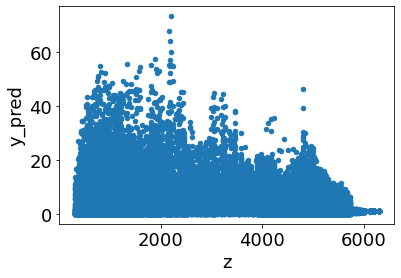

In [15]:
x_plt_df.plot.scatter(x='z', y='y_pred')
plt.savefig('z_vs_ypred_t4_hess.png', dpi=300)

In [219]:
for i in range(len(da.time.values)):
    plt.figure(figsize=(10,10))
    g = da.isel(time=i).plot.scatter(x='z', y='y_pred', hue='lon', cbar_kwargs={'label':'Longitude [°E]'})
    plt.title(" Year {:.2f}".format(da.time.values[i]))
    plt.ylim(0, 70)
    plt.xlim(0,6500)
    plt.ylabel('Precipitation [mm/day]')
    plt.xlabel('Elevation [m]')
    plt.savefig('plots/table4_gif1/output' + str(i).zfill(2) +'.png', dpi=300)
    plt.close()

In [220]:
for i in range(len(da.time.values)):
    fig= plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    g = da.isel(time=i).plot.scatter(x='z', y='y_pred', z='lon')
    plt.title("Year {:.2f}".format(da.time.values[i]))
    plt.ylim(0, 70)
    plt.xlim(0,6500)
    plt.ylabel('Precipitation [mm/day]')
    plt.xlabel('Elevation [m]')
    ax.set_zlabel('Longitude [°E]')
    plt.savefig('plots/table4_gif2/output' + str(i).zfill(2) +'.png', dpi=300)
    plt.close()

In [221]:
for i in range(len(da.time.values)):
    plt.figure(figsize=(10,10))
    g = da.isel(time=i).plot.scatter(x='z', y='y_pred', hue='lat', cbar_kwargs={'label':'Latitude [°N]'})
    plt.title(" Year {:.2f}".format(da.time.values[i]))
    plt.ylabel('Precipitation [mm/day]')
    plt.xlabel('Elevation [m]')
    plt.ylim(0, 70)
    plt.xlim(0,6500)
    plt.savefig('plots/table4_gif3/output' + str(i).zfill(2) +'.png', dpi=300)
    plt.close()

### GIF output

In [225]:
for i in range(len(da.time.values)):
    plt.figure(figsize=(10,5))
    g = da.y_pred.isel(time=i).plot(x='lon', y='lat', subplot_kws={"projection": ccrs.PlateCarree()}, vmin=0, vmax=35, extend='max', cbar_kwargs={'label':'Precipitation [mm/day]'})
    gl = g.axes.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    g.axes.set_extent([75, 83.5, 29, 34])
    g.axes.add_feature(cf.BORDERS)
    plt.title(" Year {:.2f}".format(da.time.values[i]))
    plt.savefig('plots/table4_gif4/output' + str(i).zfill(2) +'.png', dpi=300)
    plt.close()

In [239]:
plt.rcParams.update({'font.size': 18})

### Mean Posterior Seasonal Output

In [23]:
# Mean 

ds_annual_avg= da.y_pred.mean(dim='time')

ds_jun = da.y_pred[5::12]
ds_jul = da.y_pred[6::12]
ds_aug = da.y_pred[7::12]
ds_sep = da.y_pred[8::12]
ds_monsoon = xr.merge([ds_jun, ds_jul, ds_aug, ds_sep])
ds_monsoon_avg = ds_monsoon.y_pred.mean(dim='time')

ds_dec = da.y_pred[11::12]
ds_jan = da.y_pred[0::12]
ds_feb = da.y_pred[1::12]
ds_mar = da.y_pred[2::12]
ds_west = xr.merge([ds_dec, ds_jan, ds_feb, ds_mar])
ds_west_avg = ds_west.y_pred.mean(dim='time')

ds_avg_ypred = xr.concat([ds_annual_avg, ds_monsoon_avg, ds_west_avg],
                    pd.Index(["Annual", "Monsoon (JJAS)", "Winter (DJFM)"], name='t'))

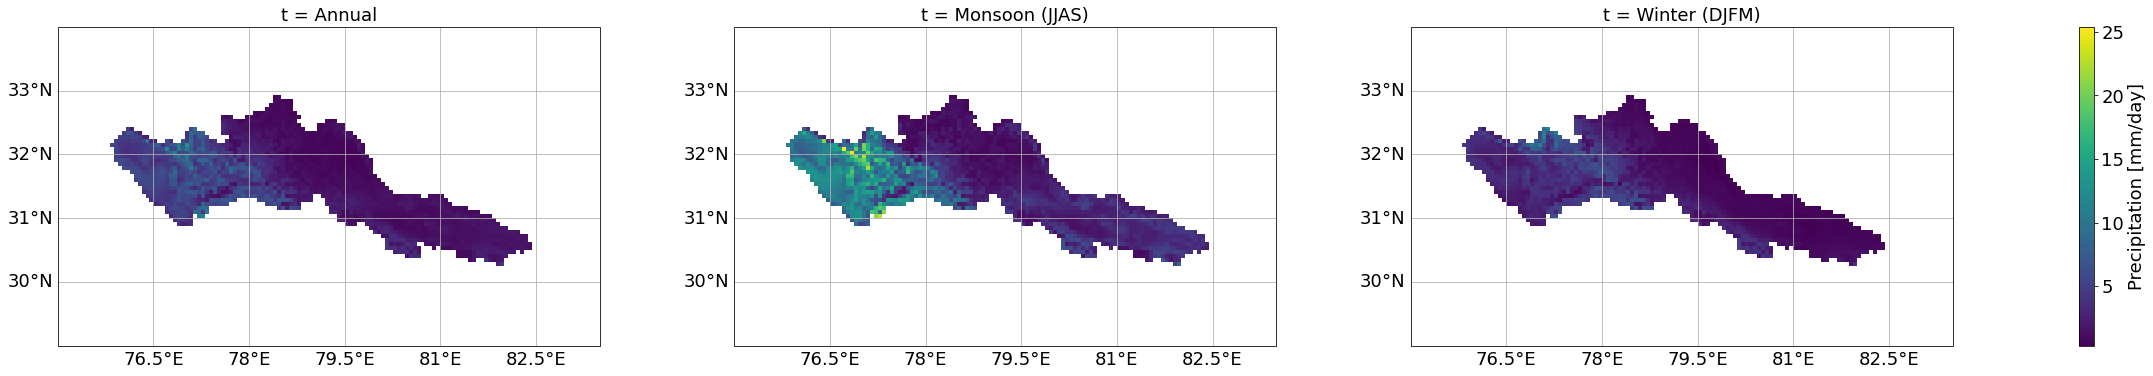

In [24]:
 # Plot maps

g = ds_avg_ypred.plot(
        x="lon",
        y="lat",
        col="t",
        cbar_kwargs={"label": "Precipitation [mm/day]"},
        size=5, aspect=2.3,
        subplot_kws={"projection": ccrs.PlateCarree()})

for ax in g.axes.flat:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([75, 83.5, 29, 34])
    ax.set_xlabel("Longitude")
    
g.axes.flat[0].set_ylabel("Latitude")
    
plt.savefig('plots/seasonal_2000-20010.png', dpi=300)

### Map of seasonal confidence interval

In [25]:
# Mean 

ds_annual_avg= da.CI.mean(dim='time')

ds_jun = da.CI[5::12]
ds_jul = da.CI[6::12]
ds_aug = da.CI[7::12]
ds_sep = da.CI[8::12]
ds_monsoon = xr.merge([ds_jun, ds_jul, ds_aug, ds_sep])
ds_monsoon_avg = ds_monsoon.CI.mean(dim='time')

ds_dec = da.CI[11::12]
ds_jan = da.CI[0::12]
ds_feb = da.CI[1::12]
ds_mar = da.CI[2::12]
ds_west = xr.merge([ds_dec, ds_jan, ds_feb, ds_mar])
ds_west_avg = ds_west.CI.mean(dim='time')

ds_avg_CI = xr.concat([ds_annual_avg, ds_monsoon_avg, ds_west_avg],
                    pd.Index(["Annual", "Monsoon (JJAS)", "Winter (DJFM)"], name='t'))

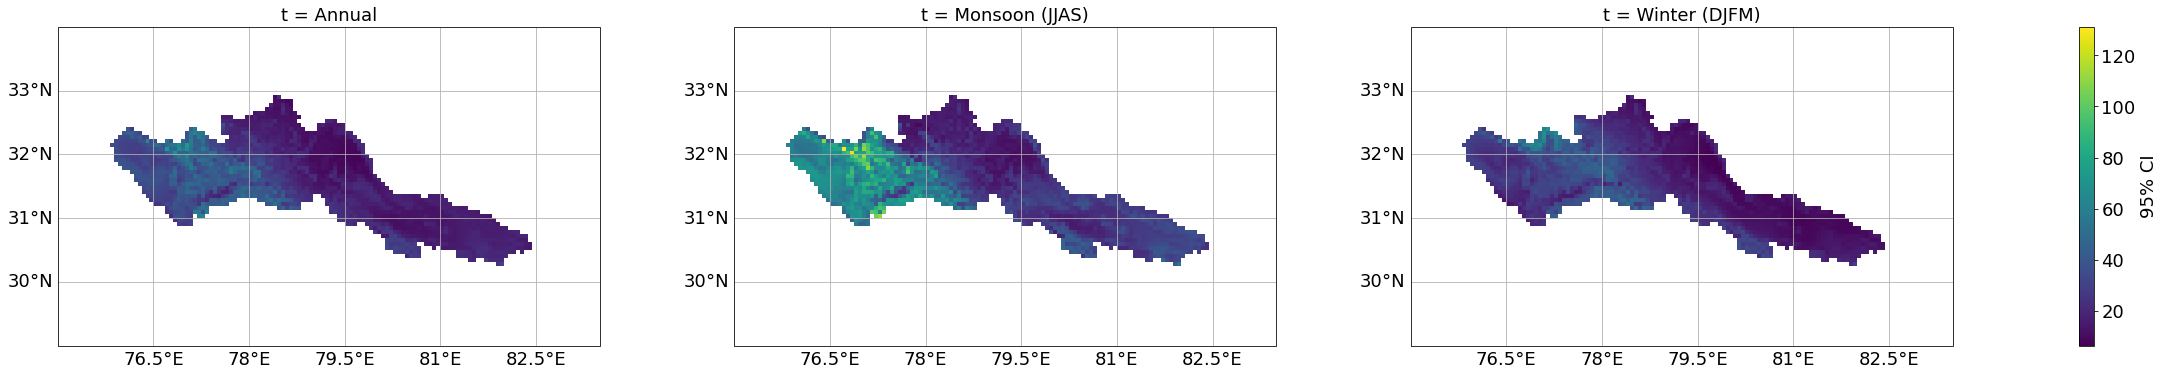

In [17]:
 # Plot maps

g = ds_avg_CI.plot(
        x="lon",
        y="lat",
        col="t",
        cbar_kwargs={"label": "95% CI"},
        size=5, aspect=2.3,
        subplot_kws={"projection": ccrs.PlateCarree()})

for ax in g.axes.flat:
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([75, 83.5, 29, 34])
    ax.set_xlabel("Longitude")
    
g.axes.flat[0].set_ylabel("Latitude")
    
plt.savefig('plots/seasonal_CI_2000-2010.png', dpi=300)

### One Bivariate Map

In [18]:
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from PIL import ImageColor
import contextily as cx

#https://waterprogramming.wordpress.com/2022/09/08/bivariate-choropleth-maps/

In [38]:
## percentile bounds defining upper boundaries of color classes
percentile_bounds = [25, 50, 75, 100]
 
### function to convert hex color to rgb to Color object (generativepy package)
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb
 
### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#be64ac')
c01 = hex_to_Color('#5ac8c8')
c11 = hex_to_Color('#3b4994')
 
### now create square grid of colors, using color interpolation from generativepy package
num_grps = len(percentile_bounds)
c00_to_c10 = []
c01_to_c11 = []
colorlist = []
for i in range(num_grps):
    c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
    c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
for i in range(num_grps):
    for j in range(num_grps):
        colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))
 
### convert back to hex color
colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

In [39]:
values = df['y_pred'].values/df['y_pred'].max()*100
ci = df['CI'].values/df['CI'].max()*100

In [40]:
def get_bivariate_choropleth_color(p1, p2):
    if p1>=0 and p2>=0:
        count = 0
        stop = False
        for percentile_bound_p1 in percentile_bounds:
            for percentile_bound_p2 in percentile_bounds:
                if (not stop) and (p1 <= percentile_bound_p1):
                    if (not stop) and (p2 <= percentile_bound_p2):
                        color = count
                        stop = True
                count += 1
    #else:
    #    color = [0.8,0.8,0.8,1]
    return color

TypeError: hist() got multiple values for argument 'x'

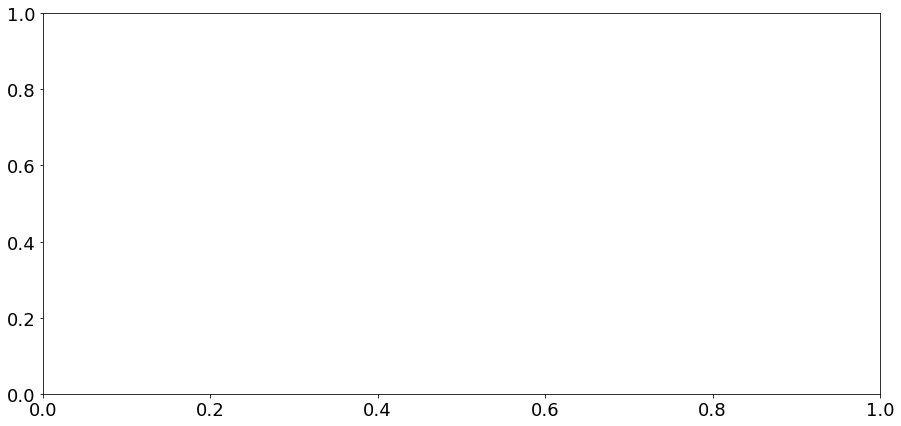

In [41]:
### function to get bivariate color given two percentiles
 
### plot map based on bivariate choropleth
df['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1, p2 in zip(values, ci)]
da2 = df.to_xarray() #set_index(['lon', 'lat']).

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()
lg = da2.color_bivariate.plot(x='lon', y='lat', colors=colorlist, add_colorbar=False, levels=np.arange(1,17), subplot_kws={"projection": ccrs.PlateCarree()}, edgecolors='none')
#gl = lg.axes.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False
plt.xlim(75, 83.5)
plt.ylim(30, 34)

### now create inset legend
ax = ax.inset_axes([0.7,0.6,0.35,0.35])
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,percentile_bound_p1 in enumerate(percentile_bounds):
    for j,percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=0.85)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)
 
_=ax.set_xlim([0,len(percentile_bounds)])
_=ax.set_ylim([0,len(percentile_bounds)])
_=ax.set_xticks(list(range(len(percentile_bounds)+1)), xticks, fontsize=12)
_=ax.set_xlabel('Mean value', fontsize=12)
_=ax.set_yticks(list(range(len(percentile_bounds)+1)), yticks, fontsize=12)
_=ax.set_ylabel('Uncertainty', fontsize=12)
 
plt.savefig('plots/bivariate.png', dpi=300)

In [42]:
df

index       z    y_pred       95th       5th  \
time        lon      lat                                                       
2000.041667 81.90625 30.28125       0  5383.0  2.046269  23.309137  0.016987   
            81.96875 30.28125       1  5071.0  4.658970  38.073089  0.124781   
            81.46875 30.34375       2  5446.0  1.002838  19.579115  0.000376   
            81.53125 30.34375       3  5237.0  0.990301  15.793942  0.001552   
            81.71875 30.34375       4  4978.0  1.924033  21.230474  0.018156   
...                               ...     ...       ...        ...       ...   
2004.958333 78.53125 32.84375  107095  4833.0  0.538285  10.767455  0.000164   
            78.59375 32.84375  107096  5025.0  0.511581   9.612032  0.000261   
            78.65625 32.84375  107097  5352.0  0.631123  12.901573  0.000159   
            78.40625 32.90625  107098  5257.0  0.706886  12.037140  0.000731   
            78.46875 32.90625  107099  5931.0  0.991012  22.132906  0.000103   

                                      CI  color_bivariate  
time        lon      lat                                   
2000.041667 81.90625 30.28125  23.292150                0  
            81.96875 30.28125  37.948309                0  
            81.46875 30.34375  19.578739                0  
            81.53125 30.34375  15.792390                0  
            81.71875 30.34375  21.212317                0  
...                                  ...              ...  
2004.958333 78.53125 32.84375  10.767291                0  
            78.59375 32.84375   9.611771                0  
            78.65625 32.84375  12.901414                0  
            78.40625 32.90625  12.036409                0  
            78.46875 32.90625  22.132803                0  

[107100 rows x 7 columns]

### Seasonal bivariate map

In [43]:
df_pred = ds_avg_ypred.to_dataframe().reset_index().dropna()
df_ci = ds_avg_CI.to_dataframe().reset_index().dropna()

In [44]:
values = df_pred['y_pred'].values/df_pred['y_pred'].max()*100
ci = df_ci['CI'].values/df_ci['CI'].values.max()*100

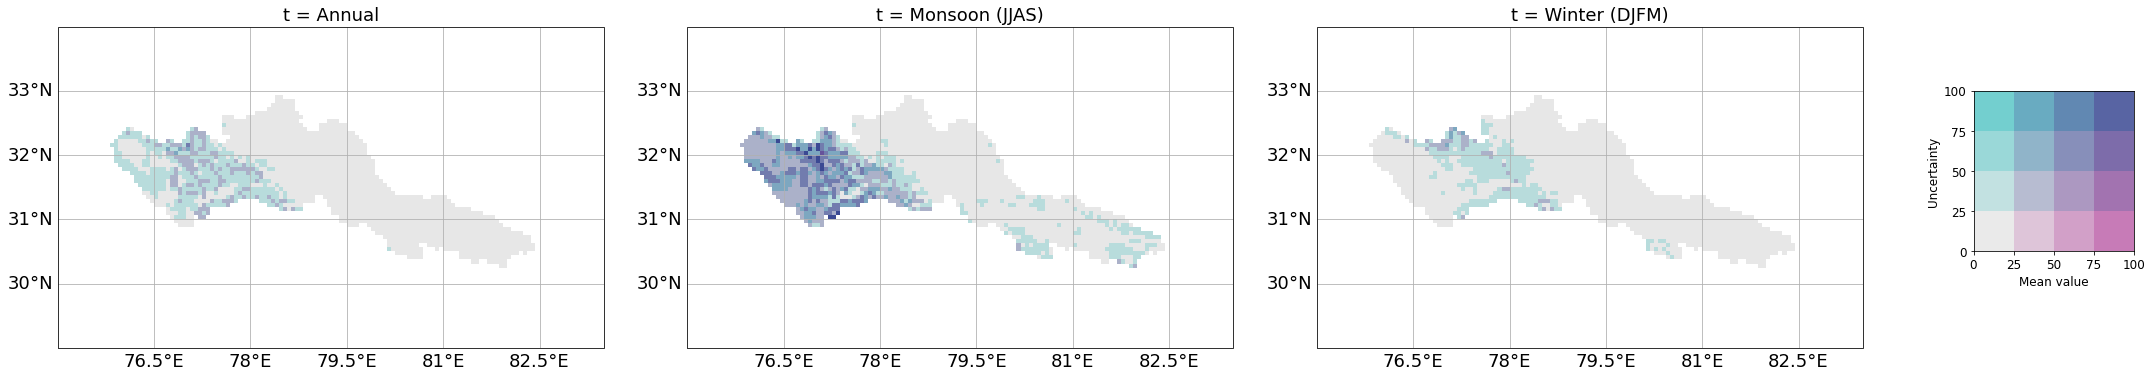

In [45]:
### plot map based on bivariate choropleth
df_pred['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1, p2 in zip(values, ci)]
da3 = df_pred.set_index(['t', 'lon', 'lat']).to_xarray()

g = da3.color_bivariate.plot(x='lon', y='lat', col='t', colors=colorlist, add_colorbar=False, levels=np.arange(1,17), 
                             size=5, aspect=1.7, subplot_kws={"projection": ccrs.PlateCarree()})

for ax in g.axes.flat:
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([75, 83.5, 29, 34])
    ax.set_xlabel("Longitude")

### now create inset legend
ax = ax.inset_axes([1.1,0.3,0.5,0.5])
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,percentile_bound_p1 in enumerate(percentile_bounds):
    for j,percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=0.85)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)
 
_=ax.set_xlim([0,len(percentile_bounds)])
_=ax.set_ylim([0,len(percentile_bounds)])
_=ax.set_xticks(list(range(len(percentile_bounds)+1)), xticks, fontsize=12)
_=ax.set_xlabel('Mean value', fontsize=12)
_=ax.set_yticks(list(range(len(percentile_bounds)+1)), yticks, fontsize=12)
_=ax.set_ylabel('Uncertainty', fontsize=12)
 
plt.savefig('plots/seasonal_bivariate.png', bbox_inches="tight", dpi=300)

### Difference Map

In [17]:
### Aprhodite
aphro_da = xr.open_dataset('/Users/kenzatazi/Documents/CDT/Code/data/APHRODITE/aphrodite_indus_1951_2016.nc')

In [234]:
mask_filepath = '/Users/kenzatazi/Documents/CDT/Code/data/Masks/Beas_Sutlej_highres_mask.nc'
mask = xr.open_dataset(mask_filepath)
aphro_interp_da = aphro_da.interp_like(mask, method='linear',) #kwargs={"fill_value": "extrapolate"})
mask_da = mask.Overlap
aphro_interp_da2 = aphro_interp_da.sel(time=slice(2000, 2005))
aphro_interp_da3 = aphro_interp_da2.where(mask_da > 0, drop=True)

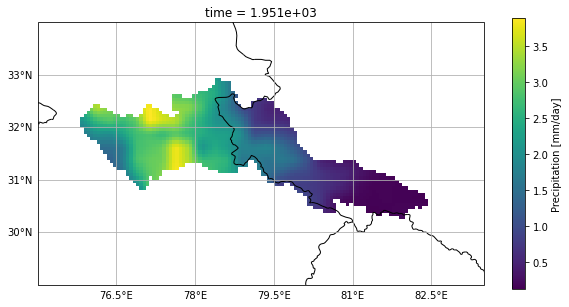

In [20]:
plt.figure(figsize=(10,5))
g = aphro_interp_da2.isel(time=0).tp.plot(x='lon', y='lat', subplot_kws={"projection": ccrs.PlateCarree()}, cbar_kwargs={'label':'Precipitation [mm/day]'})
gl = g.axes.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
g.axes.set_extent([75, 83.5, 29, 34])
g.axes.add_feature(cf.BORDERS)

In [94]:
### Difference
da['dif'] = da.y_pred - aphro_interp_da3.tp.transpose('time','lon','lat').values

In [206]:
#aphro_interp_da3.tp.transpose('time','lon','lat')

NameError: name 'aphro_interp_da3' is not defined

In [95]:
# Mean 

ds_annual_avg= da.dif.mean(dim='time')

ds_jun = da.dif[5::12]
ds_jul = da.dif[6::12]
ds_aug = da.dif[7::12]
ds_sep = da.dif[8::12]
ds_monsoon = xr.merge([ds_jun, ds_jul, ds_aug, ds_sep])
ds_monsoon_avg = ds_monsoon.dif.mean(dim='time')

ds_dec = da.dif[11::12]
ds_jan = da.dif[0::12]
ds_feb = da.dif[1::12]
ds_mar = da.dif[2::12]
ds_west = xr.merge([ds_dec, ds_jan, ds_feb, ds_mar])
ds_west_avg = ds_west.dif.mean(dim='time')

ds_avg = xr.concat([ds_annual_avg, ds_monsoon_avg, ds_west_avg],
                    pd.Index(["Annual", "Monsoon (JJAS)", "Winter (DJFM)"], name='t'))

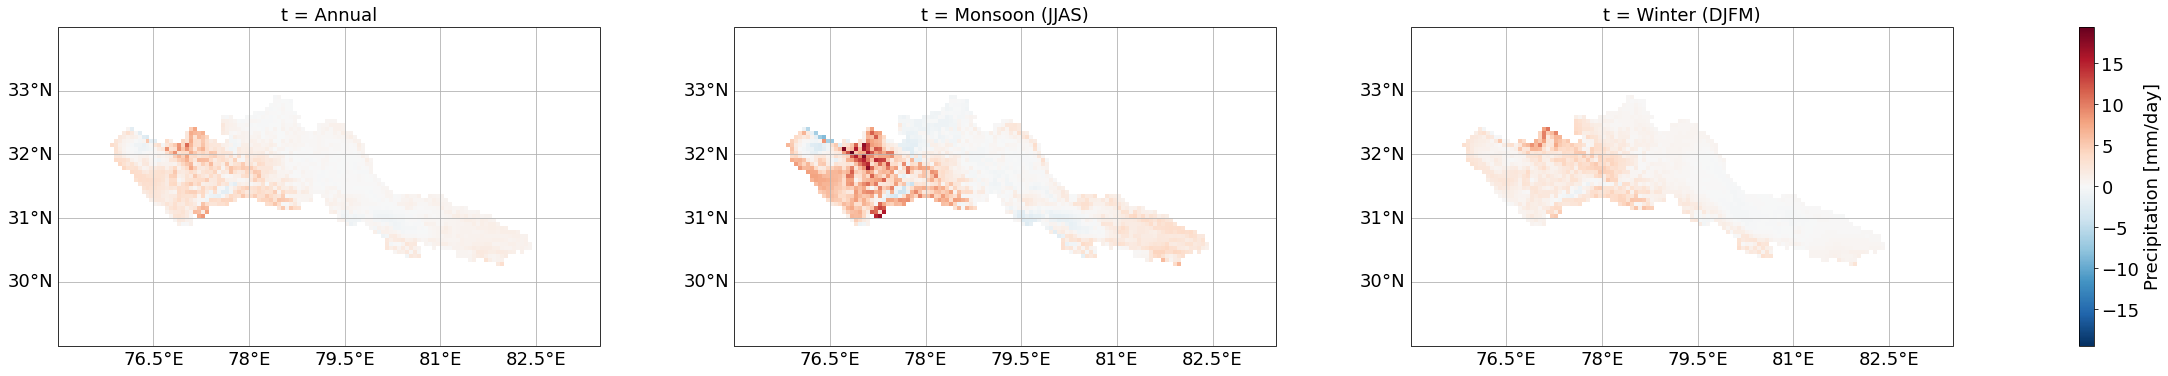

In [98]:
 # Plot maps

g = ds_avg.plot(
        x="lon",
        y="lat",
        col="t",
        cbar_kwargs={"label": "Precipitation [mm/day]"},
        size=5, aspect=2.3,
        subplot_kws={"projection": ccrs.PlateCarree()})

for ax in g.axes.flat:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([75, 83.5, 29, 34])
    ax.set_xlabel("Longitude")
    
g.axes.flat[0].set_ylabel("Latitude")
    
plt.savefig('plots/difference_2000-2005.png', dpi=300)

### Make GIF

In [226]:
import imageio as io
import os
import glob

In [228]:
images = []
for filename in sorted(glob.glob('plots/table4_gif3/*')):
    images.append(io.imread(filename))
io.mimsave('plots/output2000_2010_alt_lat.gif', images, duration = 0.5)